In [4]:
import pandas as pd

In [5]:
products = pd.read_csv('../data/products.csv')
aisles = pd.read_csv('../data/aisles.csv')
departments = pd.read_csv('../data/departments.csv')
order_products_prior = pd.read_csv('../data/order_products_prior.csv')
order_products_train = pd.read_csv('../data/order_products_train.csv')
orders = pd.read_csv('../data/orders.csv')
sample_submission = pd.read_csv('../data/sample_submission.csv')

In [6]:
#creating one big dataframe called all_orders with most of the features included. 
all_orders = pd.concat([order_products_prior,order_products_train])
all_orders = all_orders.merge(orders[['order_id','user_id']], on='order_id', how='inner')
all_orders = all_orders.merge(products, on = 'product_id', how='inner')
all_orders = all_orders.merge(departments, on = 'department_id', how='inner')
all_orders = all_orders.merge(aisles, on = 'aisle_id', how='inner')


In [7]:
#How many products the user bought from each aisle 
cnt_per_aisle = all_orders[['user_id','aisle','product_name']].groupby(['user_id', 'aisle']).count().reset_index() 

cnt_per_aisle = cnt_per_aisle.rename(columns={'product_name':'product_cnt_per_aisle'})

In [8]:
cnt_per_aisle

,user_id,aisle,product_cnt_per_aisle
0,1,candy chocolate,2
1,1,cereal,4
2,1,cream,3
3,1,fresh fruits,5
4,1,milk,1
...,...,...,...
5919835,206209,soft drinks,11
5919836,206209,soy lactosefree,10
5919837,206209,spices seasonings,1
5919838,206209,trash bags liners,1


In [9]:
#Total product purchased by user id 
ttl_per_user = cnt_per_aisle.groupby(["user_id"]).sum()
ttl_per_user

,product_cnt_per_aisle
user_id,
1,70
2,226
3,88
4,18
5,46
...,...
206205,51
206206,285
206207,223


In [10]:
#calculating the aisle share by user id 
aisle_share_per_user = cnt_per_aisle.merge(ttl_per_user, how="left", on="user_id")
aisle_share_per_user["aisle_share"] = aisle_share_per_user["product_cnt_per_aisle_x"] / aisle_share_per_user["product_cnt_per_aisle_y"]
aisle_share_per_user.drop(["product_cnt_per_aisle_x", "product_cnt_per_aisle_y"], axis=1, inplace=True)
aisle_share_per_user

,user_id,aisle,aisle_share
0,1,candy chocolate,0.028571
1,1,cereal,0.057143
2,1,cream,0.042857
3,1,fresh fruits,0.071429
4,1,milk,0.014286
...,...,...,...
5919835,206209,soft drinks,0.080292
5919836,206209,soy lactosefree,0.072993
5919837,206209,spices seasonings,0.007299
5919838,206209,trash bags liners,0.007299


In [11]:
#Setting aisles as columns by user id using pivot. 
aisle_share_pivot = aisle_share_per_user.pivot(index="user_id", columns="aisle", values="aisle_share")
aisle_share_pivot

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
user_id,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.014286,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.028571
2,NaN,0.013274,NaN,NaN,NaN,NaN,0.008850,NaN,NaN,NaN,...,0.013274,0.004425,0.004425,NaN,NaN,NaN,NaN,0.008850,NaN,0.185841
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.045455,0.011364,NaN,NaN,NaN,NaN,NaN,0.022727,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.055556,NaN,NaN,NaN,0.055556,NaN,NaN
5,0.021739,0.086957,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.065217
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206205,NaN,NaN,0.019608,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.176471
206206,NaN,0.014035,NaN,NaN,NaN,NaN,0.014035,0.003509,NaN,NaN,...,0.003509,NaN,NaN,NaN,NaN,0.003509,NaN,0.003509,NaN,NaN
206207,NaN,NaN,NaN,NaN,0.004484,NaN,NaN,NaN,NaN,NaN,...,0.013453,0.017937,NaN,0.008969,0.004484,NaN,NaN,0.049327,NaN,0.067265


In [12]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

In [13]:
#filling in nan with 0 
aisle_share_pivot.fillna(0)

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,...,0.014286,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.028571
2,0.000000,0.013274,0.000000,0.0,0.000000,0.0,0.008850,0.000000,0.0,0.0,...,0.013274,0.004425,0.004425,0.000000,0.000000,0.000000,0.0,0.008850,0.0,0.185841
3,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,...,0.045455,0.011364,0.000000,0.000000,0.000000,0.000000,0.0,0.022727,0.0,0.000000
4,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.055556,0.000000,0.000000,0.0,0.055556,0.0,0.000000
5,0.021739,0.086957,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.065217
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206205,0.000000,0.000000,0.019608,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.176471
206206,0.000000,0.014035,0.000000,0.0,0.000000,0.0,0.014035,0.003509,0.0,0.0,...,0.003509,0.000000,0.000000,0.000000,0.000000,0.003509,0.0,0.003509,0.0,0.000000
206207,0.000000,0.000000,0.000000,0.0,0.004484,0.0,0.000000,0.000000,0.0,0.0,...,0.013453,0.017937,0.000000,0.008969,0.004484,0.000000,0.0,0.049327,0.0,0.067265


In [14]:
#transforming our using PCA and finding the optimal explained variance with a given threshold of 50
pca = PCA()
pca.fit_transform(aisle_share_pivot.fillna(0))
cumsum = np.cumsum(pca.explained_variance_ratio_)
threshold = 0.50
d = np.argmax(cumsum >= threshold) + 1

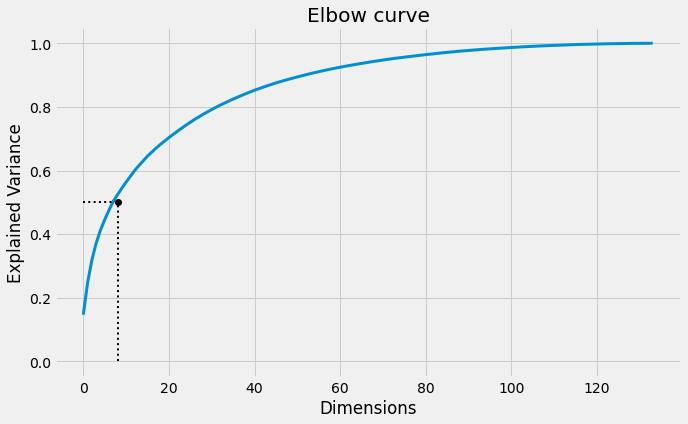

In [15]:
#graphically displaying the optimal components 
plt.style.use("fivethirtyeight")
plt.figure(figsize=(10,6))
plt.plot(cumsum, linewidth=3)
plt.title("Elbow curve")
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, threshold], "k:", linewidth=2)
plt.plot([0, d], [threshold, threshold], "k:",linewidth=2)
plt.plot(d, threshold, "ko")
plt.grid(True)
plt.show()

In [16]:
d

8

In [17]:
#creating a dataframe with d number of components. 
pca = PCA(n_components=d)
prinicpalComponents = pca.fit_transform(aisle_share_pivot.fillna(0))

PCA_components = pd.DataFrame(prinicpalComponents)

In [18]:
PCA_components

,0,1,2,3,4,5,6,7
0,-0.122382,0.028613,-0.047848,0.012765,-0.075246,-0.111782,-0.100802,0.088193
1,-0.034421,0.111616,-0.064131,-0.109468,0.073279,-0.029583,-0.049184,-0.058638
2,0.063256,0.104112,0.000496,-0.014157,-0.047738,0.111123,-0.031845,0.012987
3,-0.094301,0.052755,0.001039,-0.005059,-0.071592,-0.017788,-0.025101,-0.039019
4,0.089432,-0.031068,-0.022805,-0.011825,0.042322,0.111461,-0.015733,0.100949
...,...,...,...,...,...,...,...,...
206204,0.001716,0.084855,-0.065398,-0.068636,0.114985,-0.028533,0.020666,0.023949
206205,-0.089658,-0.046734,-0.048290,0.012790,-0.059579,-0.000557,-0.013947,-0.042961
206206,-0.024827,-0.013520,-0.003968,-0.030920,0.032989,0.020690,0.037643,0.032906
206207,-0.009310,-0.003375,-0.045595,-0.012231,0.013761,0.055675,0.008073,0.029545


In [19]:
import seaborn as sns

In [20]:
#sns.pairplot(PCA_components[range(d)])

In [21]:
from sklearn.cluster import KMeans

In [22]:
#Figuring out optimal n for epsilon
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(PCA_components[range(d)])
distances, indices = nbrs.kneighbors(PCA_components[range(d)])

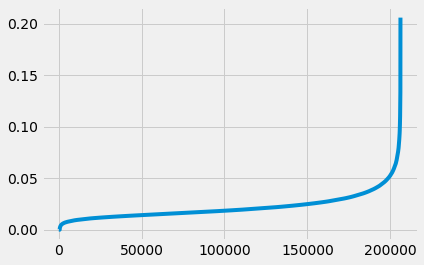

In [23]:
#elbow measuring the optimal epsilon for our DBSCAN
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

In [27]:
epsilon = 0.01
ms = 5

In [29]:
2*d

16

In [28]:
from sklearn.cluster import OPTICS
db = OPTICS(eps=epsilon, min_samples=ms, n_jobs = -1).fit(PCA_components[range(d)])
labels = db.labels_

TypeError: fit() got an unexpected keyword argument 'n_jobs'

In [1]:
'''
from sklearn.cluster import DBSCAN
db = DBSCAN(eps=epsilon, min_samples=ms).fit(PCA_components[range(d)])
labels = db.labels_

#number of clusters in labels, ignoring noise if present. 
n_clusters = len(set(labels))-(1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(pca_df, labels))
'''

NameError: name 'epsilon' is not defined

In [18]:
'''
import itertools
from sklearn.cluster import DBSCAN
import numpy as np
pca_eps_values = np.arange(0.4,1.0,0.1) 
pca_min_samples = np.arange(7,10) 
pca_dbscan_params = list(itertools.product(pca_eps_values, pca_min_samples))
pca_no_of_clusters = []
pca_sil_score = []
pca_epsvalues = []
pca_min_samp = []
for p in pca_dbscan_params:
    pca_dbscan_cluster = DBSCAN(eps=p[0], min_samples=p[1]).fit(PCA_components[range(d)])
    pca_epsvalues.append(p[0])
    pca_min_samp.append(p[1]).pca_no_of_clusters.append(
len(np.unique(pca_dbscan_cluster.labels_)))
    pca_sil_score.append(silhouette_score(pca_df, pca_dbscan_cluster.labels_))
pca_eps_min = list(zip(pca_no_of_clusters, pca_sil_score, pca_epsvalues, pca_min_samp))
pca_eps_min_df = pd.DataFrame(pca_eps_min, columns=['no_of_clusters', 'silhouette_score', 'epsilon_values', 'minimum_points'])
pca_ep_min_df
'''

In [1]:
pca_ep_min_df

NameError: name 'pca_ep_min_df' is not defined

#info on how to use elbow methodhttps://stats.stackexchange.com/questions/79470/how-to-compare-dbscan-clusters-choose-epsilon-parameter

#follow this for elbow method https://towardsdatascience.com/explaining-dbscan-clustering-18eaf5c83b31

db = DBSCAN(eps=0.2, min_samples=6).fit(pca_df)
labels = db.labels_
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(pca_df, labels))

In [ ]:
db = DBSCAN(eps=0.2, min_samples=6).fit(pca_df)
labels = db.labels_
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(pca_df, labels))

In [24]:
#DBSCAN clustering
from sklearn.cluster import DBSCAN
sse = {}
labels = {}
for ms in range(2,20):
    db_scan = DBSCAN(min_samples = ms, eps=epsilon, n_jobs=-1).fit(PCA_components[range(d)])
    sse[ms] = DBSCAN.inertia_ #what's the equivalent to this in DBSCAN? 
    labels[ms] = DBSCAN.labels_
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

AttributeError: type object 'DBSCAN' has no attribute 'inertia_'

In [20]:
#finding optimal number of clusters using kmeans
sse = {}
labels = {}
for k in range(2,20):
    kmeans = KMeans(n_clusters = k).fit(PCA_components[range(d)])
    sse[k] = kmeans.inertia_
    labels[k] = kmeans.labels_
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

In [61]:
aisle_share_pivot = aisle_share_pivot.fillna(0)

In [67]:
#concatting cluster onto 
cluster_df = pd.concat([PCA_components[range(d)],pd.Series(labels[d]).rename('cluster')], axis = 1)

cluster_df = pd.concat([pd.Series(aisle_share_pivot.index),cluster_df],axis = 1)

In [68]:
cluster_df

,user_id,0,1,2,3,4,5,6,7,cluster
0,1,-0.122382,0.028613,-0.047848,0.012766,-0.075257,-0.111785,-0.100875,0.088398,6
1,2,-0.034421,0.111616,-0.064131,-0.109468,0.073279,-0.029573,-0.049181,-0.058611,2
2,3,0.063256,0.104112,0.000496,-0.014155,-0.047741,0.111124,-0.031866,0.013089,4
3,4,-0.094301,0.052755,0.001040,-0.005059,-0.071587,-0.017777,-0.025033,-0.039054,1
4,5,0.089432,-0.031068,-0.022805,-0.011826,0.042320,0.111463,-0.015768,0.100988,0
...,...,...,...,...,...,...,...,...,...,...
206204,206205,0.001716,0.084855,-0.065398,-0.068637,0.114987,-0.028526,0.020659,0.023901,2
206205,206206,-0.089658,-0.046734,-0.048290,0.012790,-0.059584,-0.000555,-0.013935,-0.042941,1
206206,206207,-0.024827,-0.013520,-0.003968,-0.030920,0.032991,0.020688,0.037651,0.032849,0
206207,206208,-0.009310,-0.003375,-0.045594,-0.012232,0.013767,0.055678,0.008144,0.029488,0


In [66]:
cluster_df

,user_id,user_id,0,1,2,3,4,5,6,7,cluster
0,1,1,-0.122382,0.028613,-0.047848,0.012766,-0.075257,-0.111785,-0.100875,0.088398,6
1,2,2,-0.034421,0.111616,-0.064131,-0.109468,0.073279,-0.029573,-0.049181,-0.058611,2
2,3,3,0.063256,0.104112,0.000496,-0.014155,-0.047741,0.111124,-0.031866,0.013089,4
3,4,4,-0.094301,0.052755,0.001040,-0.005059,-0.071587,-0.017777,-0.025033,-0.039054,1
4,5,5,0.089432,-0.031068,-0.022805,-0.011826,0.042320,0.111463,-0.015768,0.100988,0
...,...,...,...,...,...,...,...,...,...,...,...
206204,206205,206205,0.001716,0.084855,-0.065398,-0.068637,0.114987,-0.028526,0.020659,0.023901,2
206205,206206,206206,-0.089658,-0.046734,-0.048290,0.012790,-0.059584,-0.000555,-0.013935,-0.042941,1
206206,206207,206207,-0.024827,-0.013520,-0.003968,-0.030920,0.032991,0.020688,0.037651,0.032849,0
206207,206208,206208,-0.009310,-0.003375,-0.045594,-0.012232,0.013767,0.055678,0.008144,0.029488,0


In [70]:
#Adding cluster number to our asile share per user dataframe 
cluster_aisle_br = aisle_share_per_user.merge(cluster_df[['user_id','cluster']], on = 'user_id')

In [71]:
cluster_aisle_br

,user_id,aisle,aisle_share,cluster
0,1,candy chocolate,0.028571,6
1,1,cereal,0.057143,6
2,1,cream,0.042857,6
3,1,fresh fruits,0.071429,6
4,1,milk,0.014286,6
...,...,...,...,...
5919835,206209,soft drinks,0.080292,1
5919836,206209,soy lactosefree,0.072993,1
5919837,206209,spices seasonings,0.007299,1
5919838,206209,trash bags liners,0.007299,1


In [72]:
all_orders_cluster = all_orders.merge(cluster_df[['user_id','cluster']], on = 'user_id')

In [73]:
all_orders_cluster

,order_id,product_id,add_to_cart_order,reordered,user_id,product_name,aisle_id,department_id,department,aisle,cluster
0,2,33120,1,1,202279,Organic Egg Whites,86,16,dairy eggs,eggs,0
1,104690,33120,2,1,202279,Organic Egg Whites,86,16,dairy eggs,eggs,0
2,132412,33120,1,1,202279,Organic Egg Whites,86,16,dairy eggs,eggs,0
3,2808715,33120,1,1,202279,Organic Egg Whites,86,16,dairy eggs,eggs,0
4,2894949,33120,5,0,202279,Organic Egg Whites,86,16,dairy eggs,eggs,0
...,...,...,...,...,...,...,...,...,...,...,...
33819101,2942910,36885,1,1,95228,Rose,134,5,alcohol,specialty wines champagnes,1
33819102,77392,47713,1,1,95228,Sparkling Rose,134,5,alcohol,specialty wines champagnes,1
33819103,679020,47713,1,1,95228,Sparkling Rose,134,5,alcohol,specialty wines champagnes,1
33819104,1264096,47713,1,1,95228,Sparkling Rose,134,5,alcohol,specialty wines champagnes,1
